## This notebook is for pre-processing liveability factor data

### 1. Setting up the coding environment (Nene)

In [1]:
%reset -f

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.preprocessing import RobustScaler

In [3]:
# Function to save cleaned dataframe

def save_data(dataframe, dest: str, name: str):
    file = os.path.join(dest, name)  # dest/name

    # If the file is not existing...
    if not os.path.isfile(file):
        print(f"{file} not found, saving...")
        path = os.path.split(dest)  # dest1, dest2

        # Make sure the destination file exits
        if len(path) >= 1 and path[0] != "":
            os.makedirs(os.path.join(*path), exist_ok=True)

        # Save the file
        dataframe.to_csv(file, index=False)

        print("\tDone saving.")

    else:
        print(f"Found {file} locally, done!")

    return

### 2. Reading and cleaning data (Nene & Richy)

| Metric | Data | Unit | Year | Link |
| :- | -: | :- | :-: | :- |
| 0_Boundary | Boundary | Ward | 2013 | https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london |
| 1_Transportation | PTAL | Ward | 2013* | https://data.london.gov.uk/dataset/london-ward-well-being-scores |
| 2_Neighbourhood | Green and open space access | Ward | 2013* | (same as above) |
| 3_Opportunity | Average GCSE scores | Ward | 2013* | (same as above) |
| 4_Housing | Median house price | Ward | 2014 | https://data.london.gov.uk/dataset/ward-profiles-and-atlas |
| 0_Population | Population | Ward | 2015* | (same as above) |
| 5_Environment | Pollution impact | Ward | 2008* | https://data.london.gov.uk/dataset/estimation-health-impacts-particulate-pollution-london |
| 6_Safety | Residential bulgarly | Ward | 2014 | https://data.london.gov.uk/dataset/recorded_crime_summary |

In [4]:
# Initialise the dataframe to store all data
df_combined = pd.DataFrame()

#### 0. Boundary (2018)

In [5]:
file = os.path.join('data', 'raw', 'London-wards-2013', 'London_Ward.shp')

boundary = gpd.read_file(file)

<AxesSubplot:>

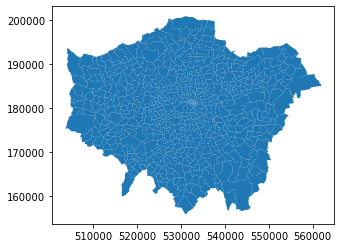

In [6]:
boundary.plot()

In [7]:
boundary.columns

Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'LB_GSS_CD', 'BOROUGH',
       'POLY_ID', 'geometry'],
      dtype='object')

In [8]:
# Cleaning up
boundary.drop(['HECTARES', 'NONLD_AREA', 'LB_GSS_CD', 'BOROUGH', 'POLY_ID'], axis=1, inplace=True)

In [9]:
boundary.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NAME      649 non-null    object  
 1   GSS_CODE  649 non-null    object  
 2   geometry  649 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 15.3+ KB


#### 1 & 2 & 3 - from well-being scores

In [10]:
# Reading in the data

file = os.path.join('data', 'raw', 'well_being_data.csv')
cols = ['Ward', 'New ward code', 'Public Transport Accessibility - 2013', 
        'Homes with access to open space & nature, and % greenspace - 2013',
        'GCSE point scores - 2013', ]

df_well_being = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [11]:
# Renaming columns
df_well_being.rename(columns={"Ward": "ward_name", 
                           "New ward code": "ward_code",
                           "GCSE point scores - 2013": "gcse_2013",
                           "Public Transport Accessibility - 2013": "ptal_2013",
                           "Homes with access to open space & nature, and % greenspace - 2013": 'nature_access_2013'},
                  inplace=True)

df_well_being.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ward_code           659 non-null    object 
 1   ward_name           657 non-null    object 
 2   gcse_2013           660 non-null    float64
 3   ptal_2013           659 non-null    float64
 4   nature_access_2013  659 non-null    float64
dtypes: float64(3), object(2)
memory usage: 27.9+ KB


In [12]:
df_well_being.head()

,ward_code,ward_name,gcse_2013,ptal_2013,nature_access_2013
0,NaN,NaN,NaN,NaN,NaN
1,E09000001,City of London,360.0,7.9,-6.5
2,E05000026,Abbey,334.0,6.0,-0.9
3,E05000027,Alibon,323.0,3.1,-1.8
4,E05000028,Becontree,319.0,2.9,-5.5


In [13]:
# Merge into the boundary data
df_merged_1 = pd.merge(boundary, df_well_being, left_on='GSS_CODE', right_on='ward_code', how='left')

# Cleaning up
df_merged_1.drop(['ward_code', 'ward_name'], axis=1, inplace=True)

In [14]:
df_merged_1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 649 entries, 0 to 648
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   NAME                649 non-null    object  
 1   GSS_CODE            649 non-null    object  
 2   geometry            649 non-null    geometry
 3   gcse_2013           624 non-null    float64 
 4   ptal_2013           624 non-null    float64 
 5   nature_access_2013  624 non-null    float64 
dtypes: float64(3), geometry(1), object(2)
memory usage: 35.5+ KB


In [15]:
#df_missing = df_merged[df_merged['ptal_2013'].isna()]
#df_missing

#### 4 - from ward atlas - Median House Price and Population

In [16]:
# Reading in the data

file = os.path.join('data', 'raw', 'ward_atlas.csv')
cols = ['Ward name', 'New code', 'Median House Price (£) - 2014', 'Population - 2015']

df_atlas = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [17]:
# Renaming columns
df_atlas.rename(columns={"Ward name": "ward_name", 
                           "New code": "ward_code",
                           "Median House Price (£) - 2014": "median_house_2014",
                           "Population - 2015": "population_2015"},
                  inplace=True)

df_atlas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ward_name          660 non-null    object 
 1   ward_code          660 non-null    object 
 2   population_2015    660 non-null    int64  
 3   median_house_2014  660 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 20.8+ KB


In [18]:
df_atlas.head()

,ward_name,ward_code,population_2015,median_house_2014
0,City of London,E09000001,8100,765000.0
1,Barking and Dagenham - Abbey,E05000026,14750,173000.0
2,Barking and Dagenham - Alibon,E05000027,10600,215000.0
3,Barking and Dagenham - Becontree,E05000028,12700,210000.0
4,Barking and Dagenham - Chadwell Heath,E05000029,10400,240500.0


In [19]:
# Merge into the boundary data
df_merged_2 = pd.merge(df_merged_1, df_atlas, left_on='GSS_CODE', right_on='ward_code', how='left')

# Cleaning up
df_merged_2.drop(['ward_name', 'ward_code'], axis=1, inplace=True)

In [20]:
df_merged_2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 649 entries, 0 to 648
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   NAME                649 non-null    object  
 1   GSS_CODE            649 non-null    object  
 2   geometry            649 non-null    geometry
 3   gcse_2013           624 non-null    float64 
 4   ptal_2013           624 non-null    float64 
 5   nature_access_2013  624 non-null    float64 
 6   population_2015     624 non-null    float64 
 7   median_house_2014   624 non-null    float64 
dtypes: float64(5), geometry(1), object(2)
memory usage: 45.6+ KB


<AxesSubplot:>

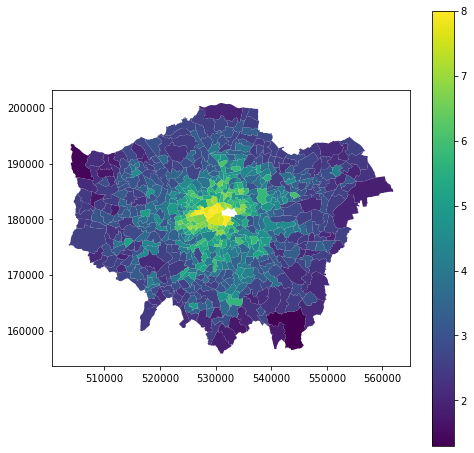

In [21]:
df_merged_2.plot(column='ptal_2013', legend=True, figsize=(8,8))

#### 5 - from pollution impact data

In [31]:
# Reading in the data

file = os.path.join('data', 'raw', 'air_pollution_mortality.csv')
cols = ['Area Code', 'Area Name', 'PM2.5 Concentration (µg/m3)']

df_pollution = pd.read_csv(file, usecols = cols, encoding= 'unicode_escape')

In [42]:
# Renaming columns
df_pollution.rename(columns={"Area Code": "ward_code", 
                           "Area Name": "ward_name",
                           "PM2.5 Concentration (µg/m3)": "pollution_2008"},
                  inplace=True)

df_pollution.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 605 entries, 0 to 625
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ward_code       605 non-null    object 
 1   ward_name       605 non-null    object 
 2   pollution_2008  605 non-null    float64
dtypes: float64(1), object(2)
memory usage: 18.9+ KB


In [49]:
df_missing = df_pollution[df_pollution['pollution_2008'].isna()]
df_missing

,ward_code,ward_name,pollution_2008


In [45]:
# Merge into the boundary data
df_merged_3 = pd.merge(df_merged_2, df_pollution, left_on='NAME', right_on='ward_name', how='left')

# Cleaning up
df_merged_3.drop(['ward_name', 'ward_code'], axis=1, inplace=True)

In [46]:
df_merged_3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 649 entries, 0 to 648
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   NAME                649 non-null    object  
 1   GSS_CODE            649 non-null    object  
 2   geometry            649 non-null    geometry
 3   gcse_2013           624 non-null    float64 
 4   ptal_2013           624 non-null    float64 
 5   nature_access_2013  624 non-null    float64 
 6   population_2015     624 non-null    float64 
 7   median_house_2014   624 non-null    float64 
 8   pollution_2008      621 non-null    float64 
dtypes: float64(6), geometry(1), object(2)
memory usage: 50.7+ KB


<AxesSubplot:>

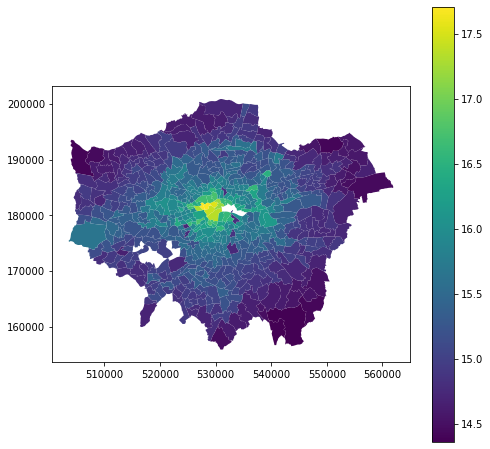

In [47]:
df_merged_3.plot(column='pollution_2008', legend=True, figsize=(8,8))

#### 6 - from crime data

#### Combine 5 dataframes into 1 based on ward name

In [28]:
# merge livability with housing to for all_data_1

all_data_1 = pd.merge(df_well_being, df_housing_and_pop, left_on='ward_code', right_on='ward_code', how='outer')

NameError: name 'df_housing_and_pop' is not defined

In [ ]:
all_data_1

In [ ]:
# merge all_data_1 with df_pollution

all_data_2 = pd.merge(all_data_1, df_pollution, left_on='ward_name_x', right_on='ward_name', how='outer')

In [ ]:
all_data_2.head(7)

In [ ]:
# merge all_data_2 with df_pollution

all_data_final = pd.merge(all_data_2, df_collision, left_on='ward_code_x', right_on='ward_code', how='outer')

In [ ]:
all_data_final

In [ ]:
all_data_final.tail(20)

#### Normalise Data

In [ ]:
all_data_final["normalised_deaths_at_6_pc"] = all_data_final["deaths_at_6_pc"]/all_data_final["Population"]

In [ ]:
normalised_all_data_final = all_data_final

In [ ]:
normalised_all_data_final["normalised_2013_collision_total"] = all_data_final["2013_collision_total"]/all_data_final["Population"]

In [ ]:
normalised_all_data_final

In [ ]:
'''
# save
if not os.path.exists('data/clean'):
    os.mkdir('data/clean')

dest = os.path.join("data", "clean")
name = "df_data_final.csv"

save_data(all_data, dest, name)
'''

### 3. Creating statistical summary of the original data (Richy)

In [ ]:
# find the mean

print(normalised_all_data_final['gcse_2013'].mean())
print(normalised_all_data_final['ptal_2013'].mean())
print(normalised_all_data_final['nature_access_2013'].mean())
print(normalised_all_data_final['median_house_2014'].mean())
print(normalised_all_data_final['normalised_deaths_at_6_pc'].mean())
print(all_data_final['2013_collision_total'].mean())






In [ ]:
# find standard dev

print(normalised_all_data_final['gcse_2013'].std())
print(normalised_all_data_final['ptal_2013'].std())
print(normalised_all_data_final['nature_access_2013'].std())
print(normalised_all_data_final['median_house_2014'].std())
print(normalised_all_data_final['normalised_deaths_at_6_pc'].std())
print(all_data_final['2013_collision_total'].std())

In [ ]:
# print the skew
print(normalised_all_data_final['gcse_2013'].skew())
print(normalised_all_data_final['ptal_2013'].skew())
print(normalised_all_data_final['nature_access_2013'].skew())
print(normalised_all_data_final['median_house_2014'].skew())
print(normalised_all_data_final['normalised_deaths_at_6_pc'].skew())
print(all_data_final['normalised_2013_collision_total'].skew())


In [ ]:
normalised_all_data_final.gcse_2013.plot.hist(bins=50)

In [ ]:
normalised_all_data_final.ptal_2013.plot.hist(bins=50)

In [ ]:
normalised_all_data_final.nature_access_2013.plot.hist(bins=50)

In [ ]:
normalised_all_data_final.median_house_2014.plot.hist(bins=50)

In [ ]:
normalised_all_data_final.normalised_deaths_at_6_pc.plot.hist(bins=50)

In [ ]:
normalised_all_data_final.normalised_2013_collision_total.plot.hist(bins=50)

| Variable | Units | Mean | Skew | Sdv. |
| :- | :- | :-: | :-: | :-: |
| GCSE Scores | - | # | # | # |
| PTAL | Density score 0-9| # | # | # |
| Nature Access Scores | Homes with access to open space, <br> and proportion of area that is greenspace| # | # | # |
| Median House Price | £ | # | # | # |
| Air Pollution Mortality | Count | # | # | # |
| Total traffic accidents | Count | # | # | # |


### 4. Normalising Data (Richy)

| Variable | Noralised | Reasoning/Method |
| :- | :- | :-: |
| GCSE Scores | No | the average of each students top 8 grades |
| PTAL | No | Effectively a density. File meta data says ‘The method is essentially a way of measuring the density of the public transport network at any location within Greater London.’
 |
| Nature Access Scores | No| its a score determined by an equal weighting of ‘Homes with access to open space, and proportion of ward that is greenspace’. I would assume they have taken homes with access to open space to be a %, and proportion to be a % too, so already normalised. | # | # |
| Median House Price | No | £ same value in each ward |
| Air Pollution Mortality | Yes | Divide by ward population  |
| Total traffic accidents | Yes | Divide by ward population |



In [ ]:
# delete colulmns that arent floats so we can rescale float columns
# note .drop doesnt seem to work and im not sure why so using del, even though its a bit less elegant!

del normalised_all_data_final["ward_code_x"]
del normalised_all_data_final["ward_name_x"]
del normalised_all_data_final["ward_name_y"]
del normalised_all_data_final["Population"]
del normalised_all_data_final["ward_code_y"]
del normalised_all_data_final["ward_name"]
del normalised_all_data_final["ward_code"]
del normalised_all_data_final["2013_collision_total"]
del normalised_all_data_final["deaths_at_6_pc"]



In [ ]:
normalised_all_data_final

In [ ]:
normalised_all_data_final.info()

### 5. Rescaling the data ready for clustering (Nene)

In [ ]:
# change index to int so rescaling works
normalised_all_data_final.index = normalised_all_data_final.index.map(int) 

In [ ]:
# second method for chagining index to int
normalised_all_data_final.index.astype(int, copy = False)

In [ ]:
# Initialise the robus recaler
rbs = RobustScaler(quantile_range=[0.05,0.95])

In [ ]:
# Rescale
standardised_all_data = []

for c in normalised_all_data_final:
    standardised_all_data[c] = rbs.fit_transform(normalised_all_data_final[c].values.reshape(-1,1))
    
# Check
standardised_all_data(3)

### 6. Summarise statistical summary of the rescaled data (Richy)